In [2]:
import numpy as np
import pandas as pd
import ta
from fbprophet import Prophet

import statsmodels
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.preprocessing import MinMaxScaler
from pykalman import KalmanFilter
np.random.seed(107)
import pywt

import sys
sys.path.append('/home/ubuntu/auquantoolbox')
from backtester.dataSource.yahoo_data_source import YahooStockDataSource
from datetime import datetime

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import plotly.offline as py
import plotly.graph_objs as go
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

# DOWNLOAD DATA FROM YAHOO

In [3]:
startDateStr = '2008/10/01'
endDateStr = '2018/10/01'
cachedFolderName = 'yahooData/'
dataSetId = 'testPairsTrading'
instrumentIds = list(set(['ITOT', 'ACWI', 'IWV', 'VT', 'VTI',
                 'DIA', 'RSP', 'IOO', 'IVV', 'SPY',
                 'SHE', 'IWM', 'OEF', 'QQQ',
                 'CVY', 'RPG', 'RPV', 'IWB', 'IWF', 
                 'IWD', 'IVW', 'IVE', 'PKW', 
                 'PRF', 'SDY', 'VV', 'VUG', 
                 'VTV', 'MGC', 'MGK', 'MGV', 'VIG', 
                 'VYM', 'DTN', 'DLN', 'MDY', 'DVY', 
                 'IWR', 'IWP', 'IWS', 'IJH', 'IJK', 
                 'IJJ', 'PDP', 'DON', 'IWC', 'IWM', 
                 'IWO', 'IWN', 'IJR', 'IJT', 'IJS', 
                 'EEB', 'IDV', 'ACWX', 'BKF', 'EFA', 
                 'EFG', 'EFV', 'SCZ', 'EEM', 'PID', 
                 'DWX', 'DEM', 'DGS', 'AAXJ', 'EZU', 
                 'EPP', 'IEV', 'ILF', 'FEZ', 'VGK', 
                 'VPL', 'DFE', 'EWA', 'EWC', 'EWG', 
                 'EWI', 'EWJ', 'EWD', 'EWL', 'EWP', 
                 'EWU', 'DXJ', 'EWZ', 'FXI', 'EWH', 
                 'EWW', 'RSX', 'EWS', 'EWM','EWY', 
                 'EWT', 'EPI', 'XLY', 'IYC', 'ITB', 
                 'XHB', 'VCR','XLP', 'IYK', 'VDC', 
                 'XLE', 'IYE', 'IGE', 'OIH', 'XOP', 
                 'VDE', 'QCLN', 'XLF','IYF', 'KBE', 
                 'KRE', 'VFH']))
ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
                            dataSetId=dataSetId,
                            instrumentIds=instrumentIds,
                            startDateStr=startDateStr,
                            endDateStr=endDateStr,
                            event='history')
data_close = ds.getBookDataByFeature()['close']
data_open = ds.getBookDataByFeature()['open']
data_high = ds.getBookDataByFeature()['high']
data_low = ds.getBookDataByFeature()['low']
data_vol = ds.getBookDataByFeature()['volume'] 

Processing data for stock: VFH
Processing data for stock: EPP
Processing data for stock: IWF
Processing data for stock: AAXJ
Processing data for stock: EPI
Processing data for stock: VYM
Processing data for stock: SPY
Processing data for stock: IWD
Processing data for stock: IWC
Processing data for stock: IWB
Processing data for stock: IWO
Processing data for stock: IWN
Processing data for stock: IWM
Processing data for stock: PID
Processing data for stock: IOO
Processing data for stock: IWV
Processing data for stock: IWS
Processing data for stock: IWR
Processing data for stock: IWP
Processing data for stock: VIG
Processing data for stock: OIH
Processing data for stock: QQQ
Processing data for stock: DTN
Processing data for stock: XLF
Processing data for stock: XLE
Processing data for stock: EEM
Processing data for stock: VDC
Processing data for stock: VDE
Processing data for stock: DEM
Processing data for stock: XLY
Processing data for stock: EEB
Processing data for stock: PKW
Process

# DATA ANALYTICS

In [4]:
print(data_close.shape)
data_close.iloc[:3,:10]

(2518, 113)


,VFH,EPP,IWF,AAXJ,EPI,VYM,SPY,IWD,IWC,IWB
2008-10-01,40.090000,35.860001,47.509998,42.340000,15.97,42.279999,116.059998,63.919998,43.880001,63.099998
2008-10-02,38.650002,33.700001,45.470001,40.700001,15.30,41.169998,111.849998,62.020000,42.090000,60.459999
2008-10-03,37.130001,33.299999,44.840000,40.169998,14.85,40.490002,110.339996,60.860001,41.020000,59.680000


In [5]:
a = pd.DataFrame({'Close':data_close.iloc[:3,1],
             'Open':data_open.iloc[:3,1],
                 'High':data_high.iloc[:3,1],
                 'Low':data_low.iloc[:3,1],
                 'Volume':data_vol.iloc[:3,1]})
print a

                Close       High        Low       Open    Volume
2008-10-01  35.860001  37.200001  34.939999  35.410000  569600.0
2008-10-02  33.700001  34.990002  33.529999  34.860001  751900.0
2008-10-03  33.299999  35.080002  33.200001  34.099998  853100.0


In [6]:
# Checking for any null values in data
d = data_close.isnull().any()
print(d[d == True])

Series([], dtype: bool)


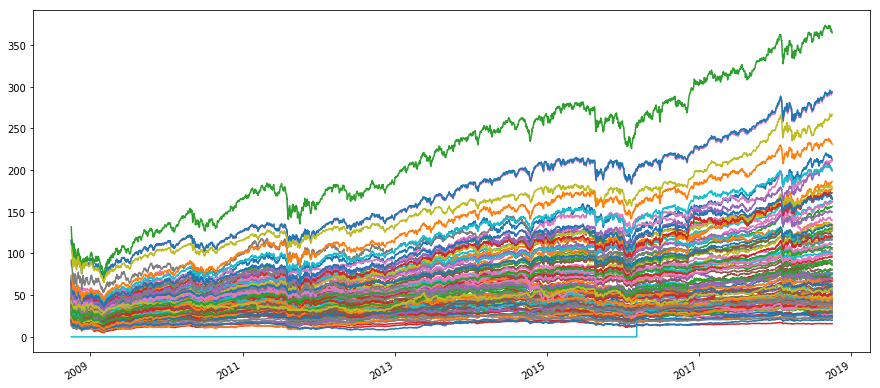

In [7]:
# Create a plot of the time series to visualize the data
for i in range(data_close.shape[1]):
    S = data_close.iloc[:, i]
    S.plot(figsize=(15,7))

# Generate Co-Integrated Pairs

In [9]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = {}
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs[(keys[i], keys[j])] = result
    return score_matrix, pvalue_matrix, pairs

scores, pvalues, pairs = find_cointegrated_pairs(data_close)

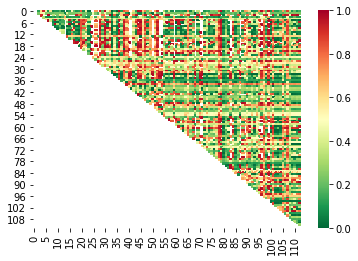

In [10]:
# Heatmap to show the p-values of the cointegration test
# between each pair of stocks
#m = [0,0.2,0.4,0.6,0.8,1]
sns.heatmap(pvalues,  cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.98)
                )
pyplot.show()

In [11]:
pairs_data = {key:value[1]  for (key, value) in pairs.items()}
pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
pairs_data[:10]

[(('SPY', 'IVV'), 0.0),
 (('IWV', 'VTI'), 1.6627551017454548e-21),
 (('IVE', 'IJJ'), 1.7380121213434282e-05),
 (('PRF', 'IVE'), 5.63604448556219e-05),
 (('VYM', 'DVY'), 6.758674613499686e-05),
 (('VFH', 'KBE'), 9.760150863380905e-05),
 (('VT', 'ACWI'), 0.00014183677751106706),
 (('DON', 'DVY'), 0.00015773162904002519),
 (('ITOT', 'VV'), 0.00016849004545661979),
 (('EWT', 'VPL'), 0.0002570590858793808)]

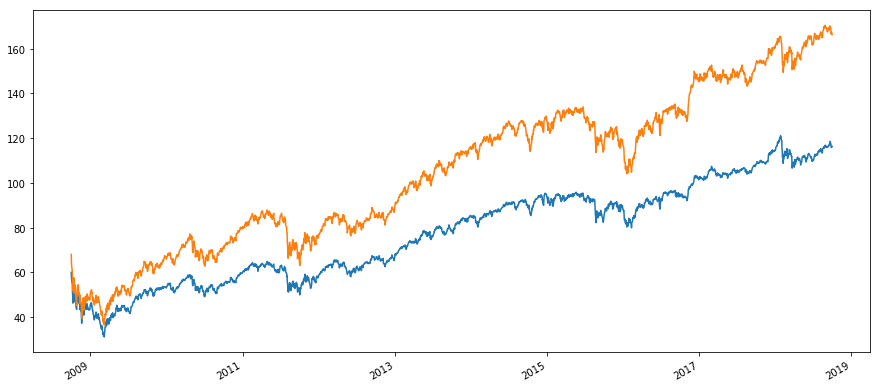

In [12]:
pair_data = pd.DataFrame({'S1_close':data_close['IVE'],'S2_close':data_close['IJJ']
                         ,'S1_open':data_open['IVE'],'S2_open':data_open['IJJ']
                         ,'S1_high':data_high['IVE'],'S2_high':data_high['IJJ']
                         ,'S1_low':data_low['IVE'],'S2_low':data_low['IJJ']
                         ,'S1_volume':data_vol['IVE'],'S2_volume':data_vol['IJJ']})
pair_data['S1_close'].plot(figsize=(15,7))
pair_data['S2_close'].plot(figsize=(15,7))

## Adding Technical Indictors

In [14]:
# add technical indicators
# 1. Momentum Indicators
# Relative Strength Index
pair_data['S1_rsi'] = ta.momentum.rsi(pair_data['S1_close'], n=14)
pair_data['S2_rsi'] = ta.momentum.rsi(pair_data['S2_close'], n=14)
# Money Flow Index
pair_data['S1_mfi'] = ta.momentum.money_flow_index(pair_data['S1_high'], pair_data['S1_low'], 
                                                   pair_data['S1_close'], pair_data['S1_volume'], n=14)
pair_data['S2_mfi'] = ta.momentum.money_flow_index(pair_data['S2_high'], pair_data['S2_low'], 
                                                   pair_data['S2_close'], pair_data['S2_volume'], n=14)

# 2. Volume Indicators
# Accumulation/Distribution Index (ADI)
pair_data['S1_adi'] = ta.volume.acc_dist_index(pair_data['S1_high'], pair_data['S1_low'], pair_data['S1_close'], pair_data['S1_volume'])
pair_data['S2_adi'] = ta.volume.acc_dist_index(pair_data['S2_high'], pair_data['S2_low'], pair_data['S2_close'], pair_data['S2_volume'])
# Volume-price trend (VPT)
pair_data['S1_vpt'] = ta.volume.volume_price_trend(pair_data['S1_close'], pair_data['S1_volume'])
pair_data['S2_vpt'] = ta.volume.volume_price_trend(pair_data['S2_close'], pair_data['S2_volume'])

# 3. Volatility Indicators
# Average True Range (ATR)
pair_data['S1_atr'] = ta.volatility.average_true_range(pair_data['S1_high'], pair_data['S1_low'], 
                                                       pair_data['S1_close'], n=14)
pair_data['S2_atr'] = ta.volatility.average_true_range(pair_data['S2_high'], pair_data['S2_low'], 
                                                       pair_data['S2_close'], n=14)
# Bollinger Bands (BB) N-period simple moving average (MA)
pair_data['S1_bb_ma'] = ta.volatility.bollinger_mavg(pair_data['S1_close'], n=20)
pair_data['S2_bb_ma'] = ta.volatility.bollinger_mavg(pair_data['S2_close'], n=20)

# 4. Trend Indicators
# Average Directional Movement Index (ADX)
pair_data['S1_adx'] = ta.trend.adx(pair_data['S1_high'], pair_data['S1_low'], pair_data['S1_close'], n=14)
pair_data['S2_adx'] = ta.trend.adx(pair_data['S2_high'], pair_data['S2_low'], pair_data['S2_close'], n=14)
# Exponential Moving Average
pair_data['S1_ema'] = ta.trend.ema_indicator(pair_data['S1_close'], n=14)
pair_data['S2_ema'] = ta.trend.ema_indicator(pair_data['S2_close'], n=14)
# Moving Average Convergence Divergence (MACD)
pair_data['S1_macd'] = ta.trend.macd(pair_data['S1_close'], n_fast=14, n_slow=30)
pair_data['S2_macd'] = ta.trend.macd(pair_data['S2_close'], n_fast=14, n_slow=30)

# 5. Other Indicators
# Daily Log Return (DLR)
pair_data['S1_dlr'] = ta.others.daily_log_return(pair_data['S1_close'])
pair_data['S2_dlr'] = ta.others.daily_log_return(pair_data['S2_close'])

## Spreads for Ground Truth

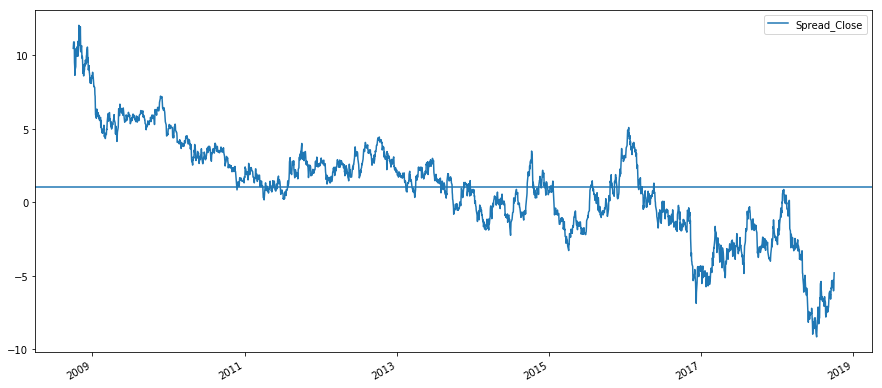

In [15]:
est = sm.OLS(pair_data.S1_close, pair_data.S2_close)
est = est.fit()
alpha = -est.params[0]
pair_data['Spread_Close'] = pair_data.S1_close + (pair_data.S2_close * alpha)
pair_data['Spread_Close'].plot(figsize=(15,7))
pyplot.axhline(pair_data['Spread_Close'].mean())
pyplot.legend(['Spread_Close'])

In [16]:
est_op = sm.OLS(pair_data.S1_open, pair_data.S2_open)
est_op = est_op.fit()
alpha_op = -est_op.params[0]
pair_data['Spread_Open'] = pair_data.S1_open + (pair_data.S2_open * alpha_op)
est_hi = sm.OLS(pair_data.S1_high, pair_data.S2_high)
est_hi = est_hi.fit()
alpha_hi = -est_hi.params[0]
pair_data['Spread_High'] = pair_data.S1_high + (pair_data.S2_high * alpha_hi)
est_lo = sm.OLS(pair_data.S1_low, pair_data.S2_low)
est_lo = est_lo.fit()
alpha_lo = -est_lo.params[0]
pair_data['Spread_Low'] = pair_data.S1_low + (pair_data.S2_low * alpha_lo)

## Wavelet Denoising

In [17]:
def wav_den(ts_orig):
    (ca, cd) = pywt.dwt(ts_orig, 'db8')
    cat = pywt.threshold(ca, np.std(ca)/8, mode='soft')
    cdt = pywt.threshold(cd, np.std(cd)/8, mode='soft')
    ts_rec = pywt.idwt(cat, cdt, 'db8')
    return ts_rec[1:]

In [18]:
#Use MinMaxScaler to normalize Weighted Price to range from 0 to 1
cols = ['Spread_Close', 'Spread_Open', 'Spread_High', 'Spread_Low', 'S1_volume',
                                          'S2_volume', 'S1_rsi', 'S2_rsi', 'S1_mfi', 'S2_mfi', 'S1_adi', 'S2_adi',
                                           'S1_vpt', 'S2_vpt', 'S1_atr', 'S2_atr', 'S1_bb_ma', 'S2_bb_ma', 'S1_adx',
                                           'S2_adx', 'S1_ema', 'S2_ema', 'S1_macd', 'S2_macd', 'S1_dlr', 'S2_dlr']
lstm_pair_data = pd.DataFrame({'Spread_Close':pair_data['Spread_Close'][30:],
                               'Spread_Open':pair_data['Spread_Open'][30:],
                               'Spread_High':pair_data['Spread_High'][30:],
                               'Spread_Low':pair_data['Spread_Low'][30:],
                               'S1_volume':pair_data['S1_volume'][30:],
                               'S2_volume':pair_data['S2_volume'][30:],
                               'S1_rsi':pair_data['S1_rsi'][30:],
                               'S2_rsi':pair_data['S2_rsi'][30:],
                               'S1_mfi':pair_data['S1_mfi'][30:],
                               'S2_mfi':pair_data['S2_mfi'][30:],
                               'S1_adi':pair_data['S1_adi'][30:],
                               'S2_adi':pair_data['S2_adi'][30:],
                               'S1_vpt':pair_data['S1_vpt'][30:],
                               'S2_vpt':pair_data['S2_vpt'][30:],
                               'S1_atr':pair_data['S1_atr'][30:],
                               'S2_atr':pair_data['S2_atr'][30:],
                               'S1_bb_ma':pair_data['S1_bb_ma'][30:],
                               'S2_bb_ma':pair_data['S2_bb_ma'][30:],
                               'S1_adx':pair_data['S1_adx'][30:],
                               'S2_adx':pair_data['S2_adx'][30:],
                               'S1_ema':pair_data['S1_ema'][30:],
                               'S2_ema':pair_data['S2_ema'][30:],
                               'S1_macd':pair_data['S1_macd'][30:],
                               'S2_macd':pair_data['S2_macd'][30:],
                               'S1_dlr':pair_data['S1_dlr'][30:],
                               'S2_dlr':pair_data['S2_dlr'][30:]
                              }, columns = cols)

In [19]:
train_size = int(len(lstm_pair_data) * 0.9)
dev_size = int((len(lstm_pair_data) - train_size) * 0.5) - 30
test_size = len(lstm_pair_data) - train_size - dev_size
train, dev, test = lstm_pair_data[0:train_size], lstm_pair_data[train_size:train_size + dev_size], lstm_pair_data[train_size + dev_size:len(lstm_pair_data)]
print(len(train), len(dev), len(test))

(2239, 94, 155)


In [20]:
train_den = pd.DataFrame(columns = cols)
for col in cols:
    train_den[col] = wav_den(train[col])

## Prediction Period Setting

In [21]:
look_back = 1

In [22]:
scaler = MinMaxScaler(feature_range=(0, 1))
# Create function for creating dataset with look back
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i, :]
        dataX.append(a)
        dataY.append(dataset[(i+1):(i+1+look_back), 0])
    print(len(dataY))
    return dataX, np.array(scaler.fit_transform(dataX)), dataY, np.array(scaler.fit_transform(dataY))

# Generate dataset for trainX, trainY, testX, testY
trainX_untr, trainX, trainY_untr, trainY = create_dataset(train_den.values, look_back)
devX_untr, devX, devY_untr, devY = create_dataset(dev.values, look_back)
testX_untr, testX, testY_untr, testY = create_dataset(test.values, look_back)

2238
93
154


## ACCURACY METRIC

In [23]:
def acc_metric(true_value, predicted_value):
    acc_met = 0.0
    m = len(true_value)
    for i in range(m):
        acc_met += mean_squared_error(true_value[i], predicted_value[i])
    acc_met /= m
    return np.sqrt(acc_met)

## Spread Prediction using Kalman Filter

In [24]:
def KalmanFilterAverage(x):
  # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01)
 
  # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means
 
# Kalman filter regression
def KalmanFilterRegression(x,y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)
 
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
    initial_state_mean=[0,0],
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=2,
    transition_covariance=trans_cov)
 
    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means

In [25]:
def normalize(series):
    return (series - np.mean(series)) / np.std(series)

In [27]:
state_means = - KalmanFilterRegression(KalmanFilterAverage(pair_data.S1_close),KalmanFilterAverage(pair_data.S2_close))[:,0]
results = normalize(pair_data.S1_close + (pair_data.S2_close * state_means))
forecast = results[-len(testX):].values
yhat_KF = forecast
yhat_KF_mse = []
mse = 0.0
if look_back == 1:
    for i in range(len(forecast)):
        temp = []
        temp.append(forecast[i])
        yhat_KF_mse.append(np.array(temp))
    mse = acc_metric(normalize(testY_untr), yhat_KF_mse)
else:
    mse = 0.0
mse

1.93467755898359

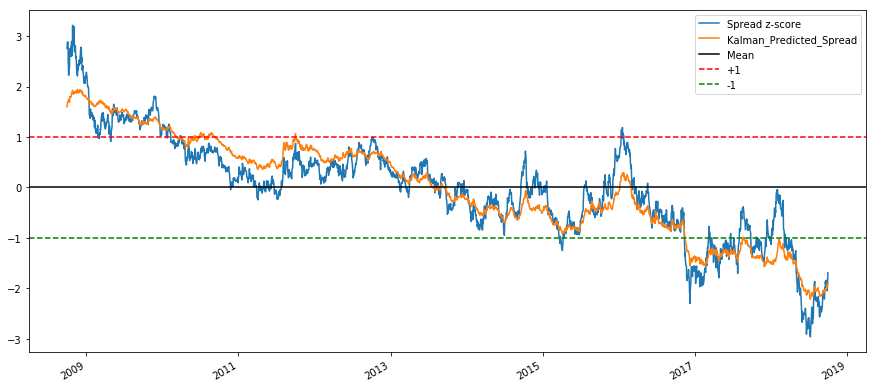

In [28]:
normalize(pair_data['Spread_Close']).plot(figsize=(15,7))
results.plot(figsize=(15,7))
pyplot.axhline(normalize(pair_data['Spread_Close']).mean(), color='black')
pyplot.axhline(1.0, color='red', linestyle='--')
pyplot.axhline(-1.0, color='green', linestyle='--')
pyplot.legend(['Spread z-score', 'Kalman_Predicted_Spread', 'Mean', '+1', '-1'])
pyplot.show()

## Spread Prediction using ARIMA

In [29]:
yhat_ARIMA = []
yhat_ARIMA_mse = []
data = lstm_pair_data['Spread_Close'].values
for i in range(train_size+dev_size, len(lstm_pair_data)-1):
    model = ARIMA(data[:i], order=(1,0,0))
    model_fit = model.fit(disp=0)
    temp = []
    forecast = (model_fit.forecast(steps=look_back)[0])
    yhat_ARIMA.append(forecast[0])
    for j in range(len(forecast)):
        temp.append(forecast[j])
    yhat_ARIMA_mse.append(np.array(temp))
mse = 0.0
mse = acc_metric(testY_untr, yhat_ARIMA_mse)
mse

0.5797150095521981

## Spread Prediction using Vector Auto-Regression Model

In [30]:
yhat_VAR_mse = []
yhat_VAR = []
data = lstm_pair_data.values
for i in range(train_size+dev_size, len(lstm_pair_data)-1):
    model = VAR(data[:i,:])
    model_fit = model.fit()
    temp = []
    forecast = model_fit.forecast(model_fit.y, steps=look_back)[:,0]
    yhat_VAR.append(forecast[0])
    for j in range(len(forecast)):
        temp.append(forecast[j])
    yhat_VAR_mse.append(np.array(temp))
mse = 0.0
mse = acc_metric(testY_untr, yhat_VAR_mse)
mse

0.579020113460353

## Spread Prediction using Facebook Prophet

In [31]:
yhat_FbProphet = []
yhat_FbProphet_mse = []
cols = ['ds', 'y']
fbData = pd.DataFrame({'ds':lstm_pair_data.index,'y':lstm_pair_data.Spread_Close}, columns = cols)
for i in range(train_size+dev_size+1, len(lstm_pair_data)):
    model = Prophet(daily_seasonality=True)
    model.fit(fbData[:i])
    temp = []
    future = model.make_future_dataframe(periods=look_back)
    forecast = (model.predict(future)).yhat[i:].values
    yhat_FbProphet.append(forecast[0])
    for j in range(len(forecast)):
        temp.append(forecast[j])
    yhat_FbProphet_mse.append(np.array(temp))
mse = 0.0
mse = acc_metric(testY_untr, yhat_FbProphet_mse)
mse

2.1973440943283844

## Spread Prediction using LSTM

In [32]:
# Reshape X for model training
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
devX = np.reshape(devX, (devX.shape[0], 1, devX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# Running the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences = True))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(look_back))
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
history = model.fit(trainX, trainY, epochs=200, batch_size=20, validation_data=(devX, devY), verbose=0, shuffle=True)

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 256)            289792    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 815,361
Trainable params: 815,361
Non-trainable params: 0
_________________________________________________________________


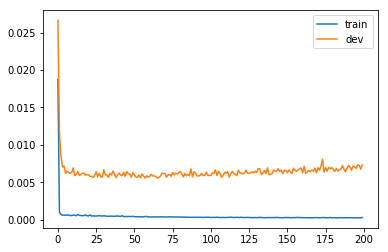

In [34]:
# Plot line graph to show amount loss according the the epoch
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='dev')
pyplot.legend()
pyplot.show()

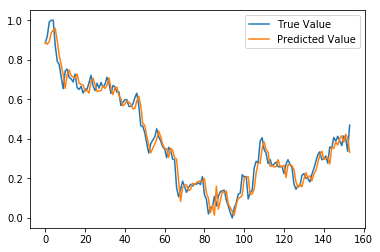

In [35]:
# Make prediction using textX and plotting line graph against testY
yhat = model.predict(testX)
pyplot.plot(testY, label='True Value')
pyplot.plot(yhat, label='Predicted Value')
pyplot.legend()
pyplot.show()

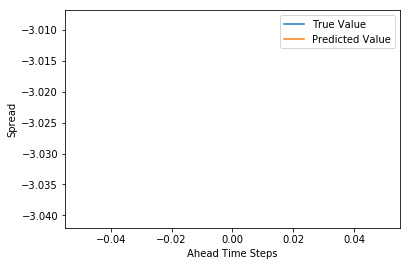

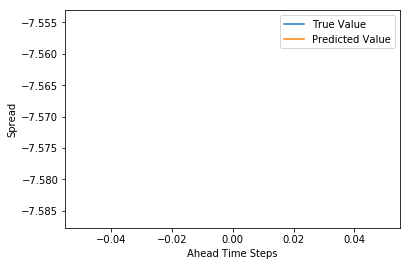

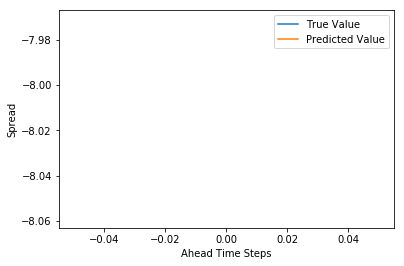

In [36]:
a=pyplot.figure(1)
pyplot.plot(scaler.inverse_transform(testY)[35:36][0], label='True Value')
pyplot.plot(scaler.inverse_transform(yhat)[35:36][0], label='Predicted Value')
pyplot.legend()
pyplot.ylabel('Spread')
pyplot.xlabel('Ahead Time Steps')
pyplot.show()
b=pyplot.figure(1)
pyplot.plot(scaler.inverse_transform(testY)[75:76][0], label='True Value')
pyplot.plot(scaler.inverse_transform(yhat)[75:76][0], label='Predicted Value')
pyplot.legend()
pyplot.ylabel('Spread')
pyplot.xlabel('Ahead Time Steps')
pyplot.show()
c=pyplot.figure(1)
pyplot.plot(scaler.inverse_transform(testY)[103:104][0], label='True Value')
pyplot.plot(scaler.inverse_transform(yhat)[103:104][0], label='Predicted Value')
pyplot.legend()
pyplot.ylabel('Spread')
pyplot.xlabel('Ahead Time Steps')
pyplot.show()

In [37]:
# Scaler Inverse Y back to normal value
yhat_LSTM = scaler.inverse_transform(yhat)
testY_LSTM = scaler.inverse_transform(testY)

In [38]:
# Training and Test error
mse_train = acc_metric(scaler.inverse_transform(trainY), scaler.inverse_transform(model.predict(trainX)))
mse_test = acc_metric(yhat_LSTM, testY_LSTM)
mse_train, mse_test

(0.16069211734808284, 0.4341993440908405)

In [45]:
predictDates = lstm_pair_data.tail(len(testX)).index
testY_reshape = normalize(testY_LSTM).reshape(len(testY_LSTM))
yhat_reshape = normalize(yhat_LSTM).reshape(len(yhat_LSTM))
kalman_reshape = normalize(yhat_KF).reshape(len(yhat_KF))
#Plot predicted and actual line graph
layout = go.Layout(
        yaxis=dict(
        title='Spread',
        titlefont=dict(
            family='Arial, sans-serif',
            size=18
        )))
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Spread')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'LSTM Predict Spread')
predict_kalman_chart = go.Scatter(x=predictDates, y=kalman_reshape, name= 'Kalman Filter Predict Spread')
fig = go.Figure(data = [predict_kalman_chart, predict_chart, actual_chart], layout = layout)
py.iplot(fig)#([predict_chart, actual_chart])

## Tuning Hyperparameters using Mean Squared Error as Metric

In [98]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
devX = np.reshape(devX, (devX.shape[0], 1, devX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# Tuning Hyperparameters
cols = ['LSTM_Lyr1', 'LSTM_Lyr2', 'Regularization', 'Epochs', 'Batch_Size', 'MSE']
MSE_Results = pd.DataFrame(columns = cols)
LSTM_lyr1 = [16, 32, 128, 256, 512]
LSTM_lyr2 = [16, 32, 128, 256, 512]
epochs = [100, 200, 300, 400, 500]
batch_size = [20, 40, 60, 80, 100]
regularization = [0.0, 0.1, 0.2, 0.3]
k = 400
l = 100
m = 0.2
for i in LSTM_lyr1:
    for j in LSTM_lyr2:
        model = Sequential()
        model.add(LSTM(i, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences = True))
        model.add(LSTM(j))
        model.add(Dropout(m))
        model.add(Dense(look_back))
        model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
        history = model.fit(trainX, trainY, epochs=k, batch_size=l, validation_data=(devX, devY), verbose=0, shuffle=True)
        yhat = model.predict(testX)
        yhat_LSTM = scaler.inverse_transform(yhat)
        testY_LSTM = scaler.inverse_transform(testY)
        mse = acc_metric(testY_LSTM, yhat_LSTM)
        MSE_Results = MSE_Results.append({'LSTM_Lyr1': i,
                                          'LSTM_Lyr2': j,
                                          'Regularization': m,
                                          'Epochs': k,
                                          'Batch_Size': l,
                                          'MSE': mse}, ignore_index=True)
MSE_Results

,LSTM_Lyr1,LSTM_Lyr2,Regularization,Epochs,Batch_Size,MSE
0,16.0,16.0,0.0,400.0,100.0,0.943567


## Trading Strategy

In [47]:
# Test Data
test_data = pd.DataFrame({'S1':pair_data['S1_close'].iloc[-len(testX):],'S2':pair_data['S2_close'].iloc[-len(testX):]})
test_data['Actual_Spread'] = pair_data['Spread_Close'].iloc[-len(testX):]
test_data['Kalman_Predicted_Spread']  = yhat_KF
test_data['ARIMA_Predicted_Spread']  = yhat_ARIMA
test_data['VAR_Predicted_Spread']  = yhat_VAR
test_data['FBProphet_Predicted_Spread']  = yhat_FbProphet
test_data['LSTM_Predicted_Spread'] = list(yhat_LSTM[:,0])
data = test_data['Actual_Spread'] 

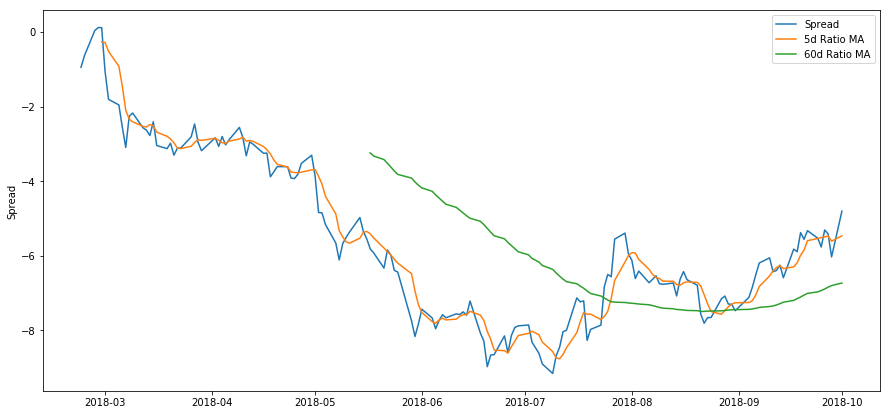

In [48]:
ratios_mavg5 = data.rolling(window=5,
                               center=False).mean()

ratios_mavg60 = data.rolling(window=60,
                               center=False).mean()

std_60 = data.rolling(window=60,
                        center=False).std()

zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
pyplot.figure(figsize=(15,7))
pyplot.plot(data.index, data.values)
pyplot.plot(ratios_mavg5.index, ratios_mavg5.values)
pyplot.plot(ratios_mavg60.index, ratios_mavg60.values)

pyplot.legend(['Spread','5d Ratio MA', '60d Ratio MA'])

pyplot.ylabel('Spread')
pyplot.show()

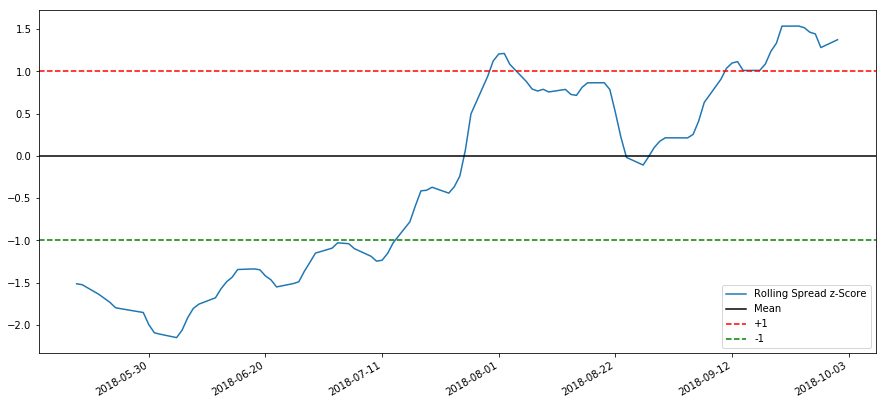

In [49]:
# Take a rolling 60 day standard deviation
std_60 = data.rolling(window=60,center=False).std()
std_60.name = 'std 60d'

# Compute the z score for each day
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
zscore_60_5.name = 'z-score'

pyplot.figure(figsize=(15,7))
zscore_60_5.plot()
pyplot.axhline(0, color='black')
pyplot.axhline(1.0, color='red', linestyle='--')
pyplot.axhline(-1.0, color='green', linestyle='--')
pyplot.legend(['Rolling Spread z-Score', 'Mean', '+1', '-1'])
pyplot.show()

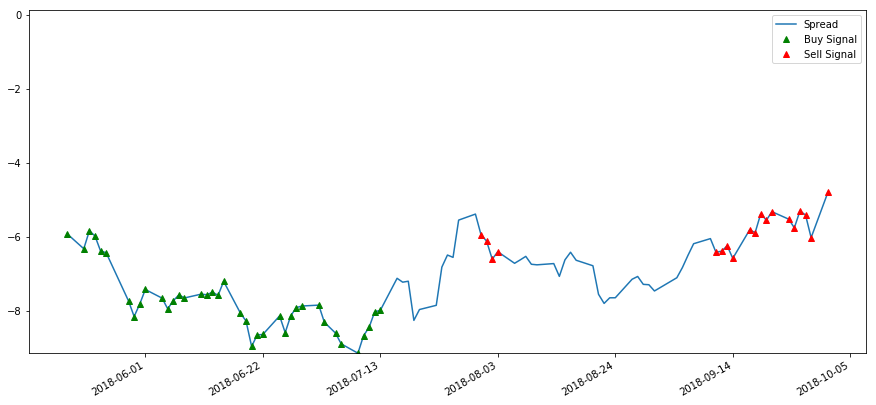

In [50]:
# Plot the ratios and buy and sell signals from z score
pyplot.figure(figsize=(15,7))

data[60:].plot()
buy = data.copy()
sell = data.copy()
buy[zscore_60_5>-1] = -100
sell[zscore_60_5<1] = -100
buy[60:].plot(color='g', linestyle='None', marker='^')
sell[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = pyplot.axis()
pyplot.axis((x1,x2,data.min(),data.max()))
pyplot.legend(['Spread', 'Buy Signal', 'Sell Signal'])
pyplot.show()

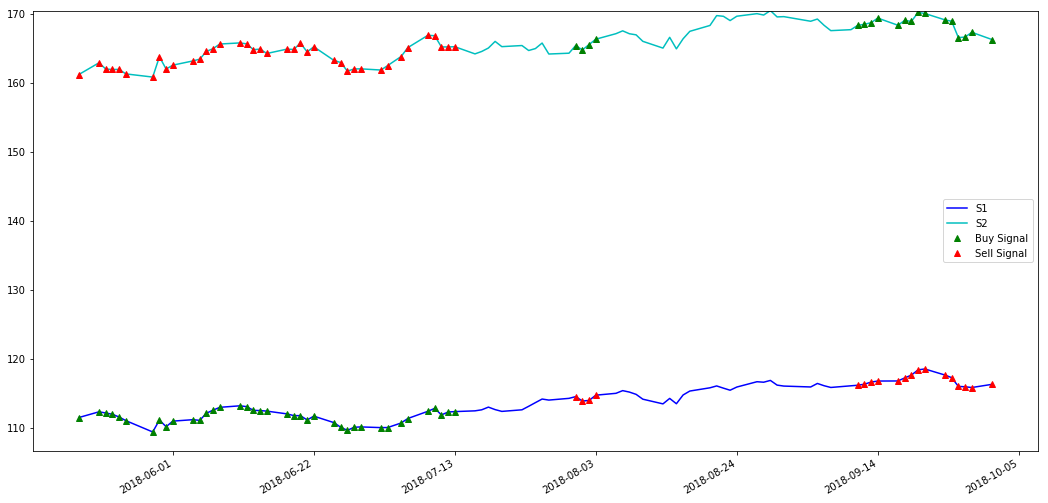

In [51]:
# Plot the prices and buy and sell signals from z score
pyplot.figure(figsize=(18,9))
S1 = test_data.S1
S2 = test_data.S2

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When buying the ratio, buy S1 and sell S2
buyR[buy!=-100] = S1[buy!=-100]
sellR[buy!=-100] = S2[buy!=-100]
# When selling the ratio, sell S1 and buy S2 
buyR[sell!=-100] = S2[sell!=-100]
sellR[sell!=-100] = S1[sell!=-100]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = pyplot.axis()
pyplot.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))

pyplot.legend(['S1', 'S2', 'Buy Signal', 'Sell Signal'])
pyplot.show()

In [52]:
def trade(S1, S2, spread, window1, window2):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    # Compute rolling mean and rolling standard deviation
    ma1 = spread.rolling(window=window1, center=False).mean()
    ma2 = spread.rolling(window=window2, center=False).mean()
    std = spread.rolling(window=window2, center=False).std()
    zscore = (ma1 - ma2)/std
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(spread)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            money += S1[i] - S2[i] * spread[i]
            countS1 -= 1
            countS2 += spread[i]
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:
            money -= S1[i] - S2[i] * spread[i]
            countS1 += 1
            countS2 -= spread[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.5:
            money += countS1 * S1[i] - S2[i] * countS2
            countS1 = 0
            countS2 = 0
    return money

In [53]:
data = test_data['Actual_Spread'] 
profit = trade(test_data['S1'], test_data['S2'], data, 30, 5)
profit

91964.78343828625

In [112]:
# Actual Spread
# 91964.78343828625
# Kalman Filter
# 29959.723177883072
# ARIMA
# 64448.09898119516
# VAR
# 64580.88216334411
# FB Prophet
# 49316.91921868784
# LSTM
# 70589.74374960671